In [66]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from __future__ import print_function
from sklearn import preprocessing
from time import time
# from sklearn.cross_validation import train_test_split
# from sklearn.grid_search import GridSearchCV
# from sklearn.metrics import classification_report
# from sklearn.svm import SVC
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.kernel_ridge import KernelRidge
import numpy as np
import sklearn.decomposition
import sklearn.metrics
from sklearn import gaussian_process
from sklearn import cross_validation
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.ensemble import RandomForestClassifier

np.random.seed(1234)

horseData = np.array(pd.read_excel('Horse.xlsx').values)
horseData = np.vstack({tuple(row) for row in horseData})


# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1, 1e-1, 1e-2, 1e-3, 1e-4],
#                      'C': [1e-1, 1,10,100,1000]},
#                     {'kernel': ['linear'], 'C': [1,0.1,0.01,0.001,0.0001]}]

# scores = ['precision', 'recall']

X_train_O, X_test, y_train, y_test = train_test_split(
    horseData[:, :-1] , horseData[:, -1:horseData[0].size], test_size=0.2, random_state=0)

y_train = y_train.reshape(len(y_train),).astype(int) + (np.random.random_sample((len(y_train),))-1) + np.random.random_sample((len(y_train),))
y_test = y_test.reshape(len(y_test),).astype(int) + (np.random.random_sample((len(y_test),))-1) + np.random.random_sample((len(y_test),))

X_train = preprocessing.scale(X_train_O)

# print(np.any(np.isnan(X_train)))
# print(np.all(np.isfinite(X_train)))
# print(horseData.isnull().any())


param_grid = {"theta0": [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07],
              "nugget": [0.01, 0.02, 0.03]}

clf = gaussian_process.GaussianProcess()
# print(clf.get_params().keys())
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X_train, y_train)

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

report(grid_search.cv_results_)



    


GridSearchCV took 0.26 seconds for 24 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.407 (std: 0.080)
Parameters: {'nugget': 0.03, 'theta0': 0.02}

Model with rank: 2
Mean validation score: 0.402 (std: 0.116)
Parameters: {'nugget': 0.03, 'theta0': 0.01}

Model with rank: 3
Mean validation score: 0.393 (std: 0.108)
Parameters: {'nugget': 0.02, 'theta0': 0.01}



Train score R2: 0.983672033722
Test score R2: 0.843193863975


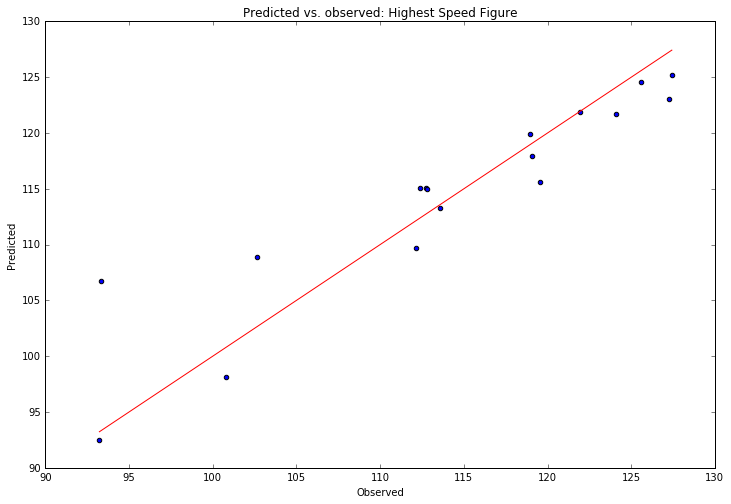

[ 121.69415445  119.88120949  117.94484752  106.77586936  121.89037097
  113.25877971  115.60353776  115.0422407   114.99504018  123.06587743
  108.92108942  109.71245023  115.09623491   98.0925102   125.2282348
  124.57776151   92.46153542]
[ 124.10296532  118.95567859  119.10002482   93.32989532  121.92375169
  113.5592714   119.54560901  112.75865037  112.78307022  127.28519788
  102.61839196  112.13600274  112.37117245  100.81816543  127.42574919
  125.55834409   93.22891808]


In [71]:
# def crossValidation_all(theta, nugget, nfold, trainX, trainY):
#     thetaU = theta * 2
#     thetaL = theta/2
    
#     scores = np.zeros((len(nugget) * len(theta), nfold))
#     labels = ["" for x in range(len(nugget) * len(theta))]

#     k = 0
#     for j in range(len(theta)):
#         for i in range(len(nugget)):
#             gp = gaussian_process.GaussianProcess(theta0 = theta[j], nugget = nugget[i])
#             scores[k, :] = cross_validation.cross_val_score(gp, trainX, trainY, scoring='r2', cv = nfold)  
#             labels[k] = str(theta[j]) + '|' + str(nugget[i])  
#             k = k + 1
    
#     plt.figure(figsize=(30,8))
#     plt.boxplot(scores.T, sym='b+', labels = labels, whis = 0.5)
#     plt.ylim([0,1])
#     plt.title('R2 score as a function of nugget')
#     plt.ylabel('R2 Score')
#     plt.xlabel('Choice of theta | nugget')
#     plt.show()
    
# theta = np.arange(0.01, 0.05, 0.01)
# nfold = 3
# nugget = np.arange(0.01, 0.05, 0.01)

# crossValidation_all(theta, nugget, nfold, X_train, y_train)


def predictAll(theta, nugget, trainX, trainY, testX, testY, testSet, title):

    gp = gaussian_process.GaussianProcess(theta0=theta, nugget =nugget)
    gp.fit(trainX, trainY)

    predictedY, MSE = gp.predict(testX, eval_MSE = True)
    sigma = np.sqrt(MSE)
    
    results = {}
    results['predictedY'] = predictedY
    results['sigma'] = sigma

    print ("Train score R2:", gp.score(trainX, trainY))
    print ("Test score R2:", sklearn.metrics.r2_score(testY, predictedY))

    plt.figure(figsize = (12,8))
    plt.scatter(testY, predictedY)
    plt.plot([min(testY), max(testY)], [min(testY), max(testY)], 'r')
    plt.xlim(90, 130)
    plt.ylim(90, 130)
#     plt.xlim([min(testY)[0], max(testY)[0]])
#     plt.ylim([min(testY)[0], max(testY)[0]])
    plt.title('Predicted vs. observed: ' + title)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    plt.show()
    
    return gp, results

gp, results = predictAll(0.02, 0.01, X_train_O, y_train, 
                                  X_test, y_test, X_test, 'Highest Speed Figure')

print(results['predictedY'])
print(y_test)

